Start of 6.6: Cliff Walking 2018-09-17 09:13:32.664696


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.28s/it]


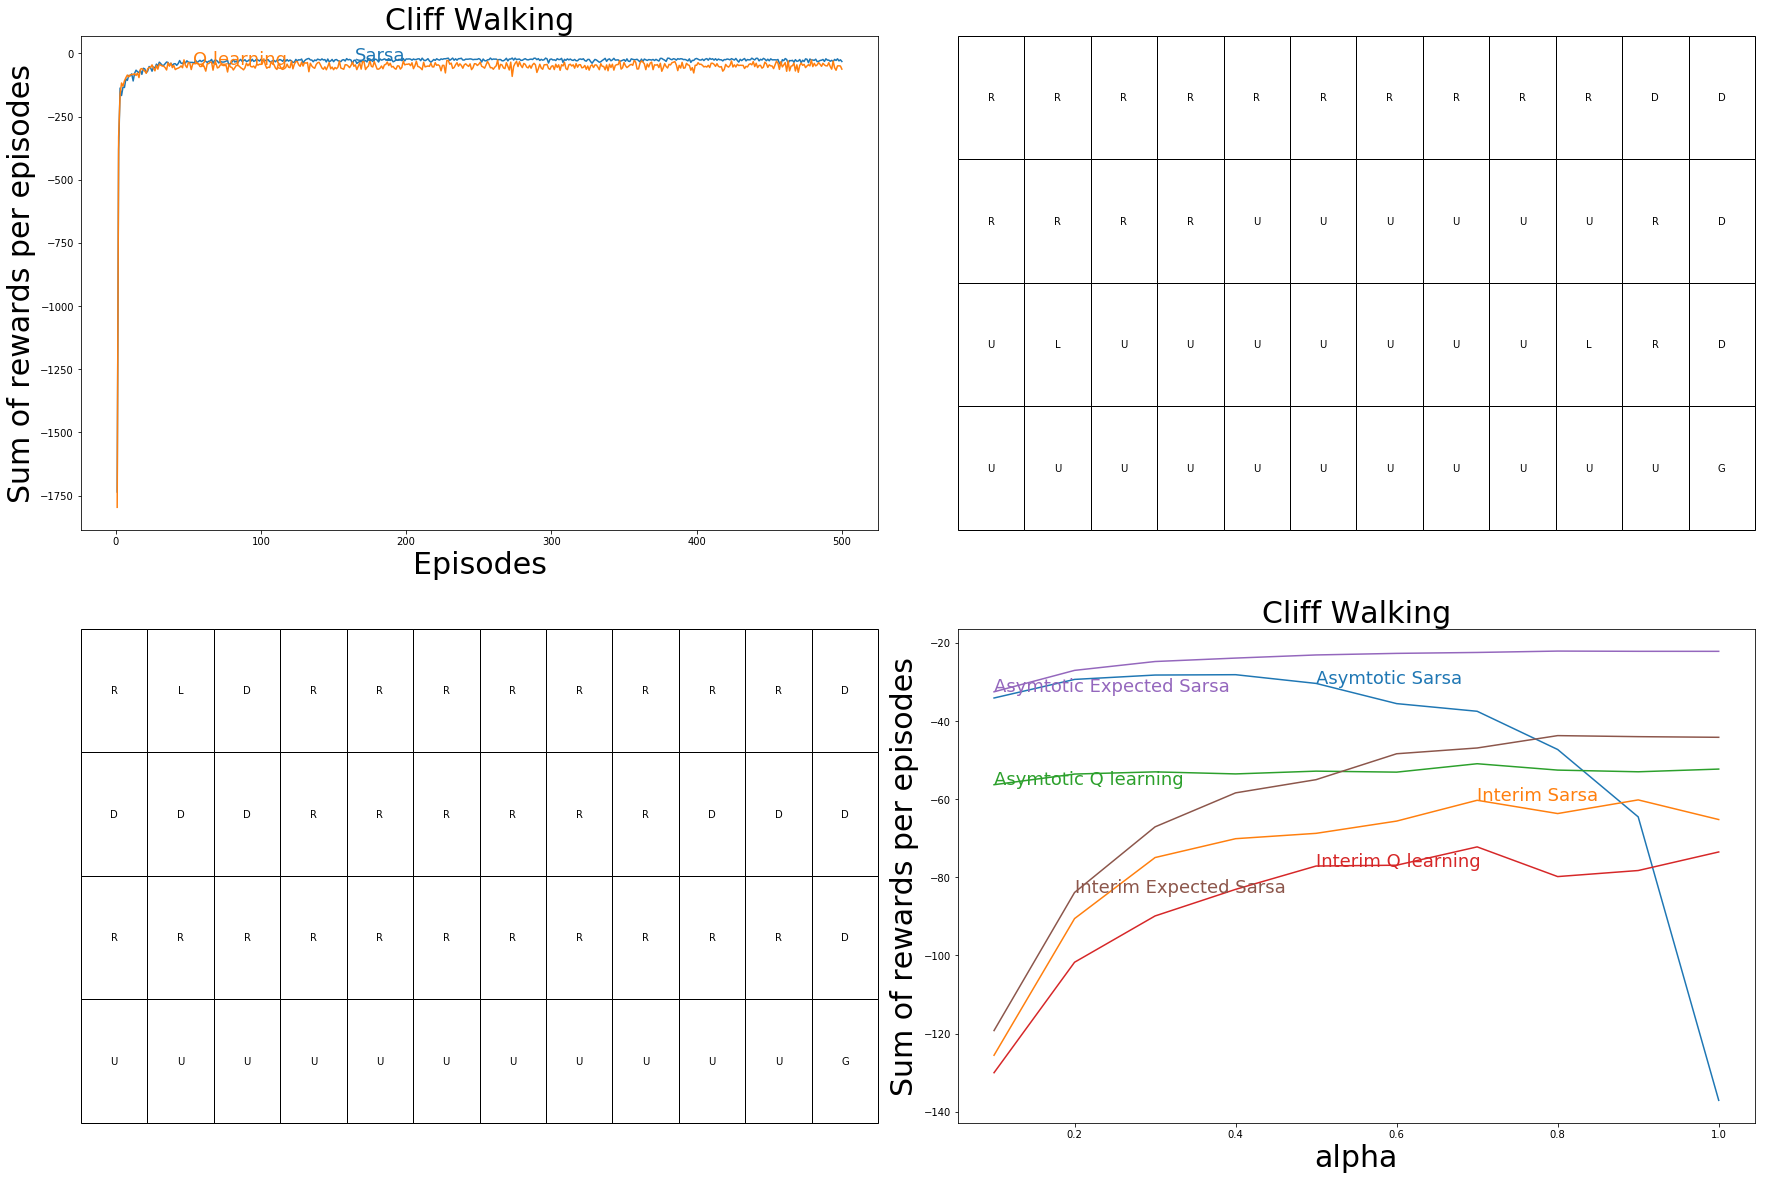


End of Cliff Walking 2018-09-17 09:20:01.196887
Running Time 0:06:28.532191


In [2]:
"""Example 6.6: Cliff Walking
Author : SeongJin Yoon
"""
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random
from tqdm import tqdm

debug_mode = False
class Action():
    up = 0
    down = 1
    left = 2
    right = 3
    
    @staticmethod
    def to_str(action):
        assert action == Action.left or action == Action.right \
            or action == Action.up or action == Action.down 
        strlist = ["up", "down", "left", "right"]
        return strlist[action]
    
    def to_char(action):
        assert action == Action.left or action == Action.right \
            or action == Action.up or action == Action.down 
        strlist = ['U', 'D', 'L', 'R']
        return strlist[action]
    
class Pos():
    
    def __init__(self, row, col):
        assert (0 <= row and row < 4) and (0 <= col and col < 12)
        self.row = row
        self.col = col
        
    def validate(self):
        if (0 <= self.row and self.row < 4) and \
            (0 <= self.col and self.col < 12) :
            return True
        return False
        
class CliffWalking():
    def __init__(self):
        self.GRID_HEIGHT = 4
        self.GRID_WIDTH = 12
        self.start = Pos(3,0)
        self.terminal = Pos(3,11)
        self.discount = 1
        self.epsilon = 0.1
        self.plot = Plot(nrows=2, ncols=2, figsize=(30,20))
    
    def init_q_value(self):
        q_value = np.zeros((self.GRID_HEIGHT,self.GRID_WIDTH,4))
        return q_value

    def get_reward(self, state):
        if self.is_cliff(state): return -100
        if self.is_terminal(state): return 0
        return -1.0
    
    def is_cliff(self, state):
        if state.row == (self.GRID_HEIGHT-1)\
            and 0 < state.col and state.col < (self.GRID_WIDTH-1):
            return True
        return False
    
    def is_terminal(self, state):
        if state.row == self.terminal.row and state.col == self.terminal.col :
            return True
        return False

    def get_random_action(self, state):
        assert state.validate()

        candidate = np.ones(4)
        action = self.pick_best(candidate)
        return action

    def get_greedy_action(self, q_value, state):        
        assert state.validate()
        
        action = self.pick_best(q_value[state.row, state.col])
        return action

    def pick_best(self, candidate):
        max_list = np.argwhere(candidate[:] == np.max(candidate)).flatten()
        action = np.random.choice(max_list)
        return action
    
    def e_greedy_policy(self, q_value, state):

        if np.random.binomial(1, self.epsilon) == 1:
            action = self.get_random_action(state)
        else:
            action = self.get_greedy_action(q_value, state)
            
        return action

    def do_action(self, state, action):      
        if action == Action.up:
            n_state = Pos(max(state.row-1, 0), state.col)
        elif action == Action.down:
            n_state = Pos(min(state.row+1, self.GRID_HEIGHT-1), state.col)
        elif action == Action.left:
            n_state =  Pos(max(state.row, 0), max(state.col-1, 0))
        elif action == Action.right:
            n_state =  Pos(max(state.row, 0), min(state.col+1, self.GRID_WIDTH-1))
            
        reward = self.get_reward(n_state)
        
        if self.is_cliff(n_state):
            n_state = self.start

        return n_state, reward
    
    def exptected_value(self, q_value_tuple):
            n_value = 0
            n_best_actions = np.argwhere(q_value_tuple == np.max(q_value_tuple))
            num_actions = len(q_value_tuple)
            for n_action, n_q_value in enumerate(q_value_tuple):
                prob = self.epsilon/num_actions
                if n_action in n_best_actions:
                    prob += (1 - self.epsilon)/len(n_best_actions)
                n_value += prob*n_q_value
                
            return n_value
 
    def td_control(self, method, q_value, alpha):
        # initial state
        state = self.start
        action = self.e_greedy_policy(q_value, state)
        
        step = 0
        sum_of_reward = 0
        while self.is_terminal(state) is False:
            step += 1
            
            # One step ahead
            n_state, reward = self.do_action(state, action)
            n_action = self.e_greedy_policy(q_value, n_state)
            sum_of_reward += reward
            if method == "Sarsa":
                n_value = q_value[n_state.row, n_state.col, n_action]
            elif method == "Q learning":
                n_max_action = self.get_greedy_action(q_value, n_state)
                n_value = q_value[n_state.row, n_state.col, n_max_action]
            elif method == "Expected Sarsa":
                q_value_tuple = q_value[n_state.row, n_state.col, :]
                n_value = self.exptected_value(q_value_tuple)

            # Q value update
            error = reward + self.discount*n_value\
                - q_value[state.row, state.col, action]
                
            q_value[state.row, state.col, action] += alpha*error
            if debug_mode:
                print("step %d : state (%d, %d) action %s -> "
                      "reward %d, next_state (%d, %d) next action %s, sum of reward %d" %
                      (step, state.row, state.col, Action.to_str(action), 
                       reward, n_state.row, n_state.col, 
                       Action.to_str(n_action), sum_of_reward))
            state = n_state
            action = n_action
            
        step += 1                
        return sum_of_reward
        
    def draw_6_6_plot(self):

        labels = ['Episodes', 'Sum of rewards per episodes', 'Cliff Walking']
        
        ax = self.plot.draw_mline_begin(labels)
        q_value1 = self.draw_method_plot(ax, "Sarsa")
        q_value2 = self.draw_method_plot(ax, "Q learning")
        self.plot.draw_mline_end()
        
        self.draw_optimal_policy(q_value1)
        self.draw_optimal_policy(q_value2)
        
    def draw_method_plot(self, ax, method):
        alpha = 0.5
        num_runs = 50
        num_episode = 500
        
        avg_sums = np.zeros(num_episode)
        for run in tqdm(range(num_runs)):
            q_value = self.init_q_value()
            sum_of_rewards = np.zeros(num_episode)
    
            for episode_idx in range(num_episode):
                sum_of_reward = self.td_control(method, q_value, alpha)
                sum_of_rewards[episode_idx] = sum_of_reward
            avg_sums += sum_of_rewards
            
        avg_sums /= num_runs
        episode_list = np.arange(1, num_episode + 1)
        label = method
        self.plot.draw_mline(ax, episode_list, avg_sums, label)
        
        return q_value

    def draw_optimal_policy(self, q_value):
        policy = np.full((self.GRID_HEIGHT, self.GRID_WIDTH), '')

        for row in range(self.GRID_HEIGHT):
            for col in range(self.GRID_WIDTH):
                action = np.argmax(q_value[row, col])
                policy[row, col] = Action.to_char(action)
                
        policy[self.terminal.row, self.terminal.col] = 'G'
        
        self.plot.draw_table(policy)
       
    def draw_figure_6_3_plot(self):
        labels = ['alpha', 'Sum of rewards per episodes', 'Cliff Walking']
        
        num_runs = 10
        num_episode = 1000
        
        ax = self.plot.draw_mline_begin(labels)
        self.draw_method_plot2(ax, "Sarsa", num_runs, num_episode)
        self.draw_method_plot2(ax, "Q learning", num_runs, num_episode)
        self.draw_method_plot2(ax, "Expected Sarsa", num_runs, num_episode)
        self.plot.draw_mline_end()
        self.plot.show()

    def draw_method_plot2(self, ax, method, num_runs, num_episode):
        alpha_range = np.arange(0.1, 1.1, 0.1)
        len_range = len(alpha_range)
        sum_of_rewards = np.zeros(len_range)
        sum_of_rewards_100 = np.zeros(len_range)
        
        for run in tqdm(range(num_runs)):
            for alpha_i, alpha in enumerate(alpha_range):
                q_value = self.init_q_value()
                for episode_idx in range(num_episode):
                    sum_of_reward = self.td_control(method, q_value, alpha)          
                    sum_of_rewards[alpha_i] += sum_of_reward
                    if episode_idx < 100:
                        sum_of_rewards_100[alpha_i] += sum_of_reward

        sum_of_rewards /= num_runs*num_episode
        sum_of_rewards_100 /= num_runs*100
        
        label = "Asymtotic " + method
        self.plot.draw_mline(ax, alpha_range, sum_of_rewards, label)
        label =  "Interim " + method
        self.plot.draw_mline(ax, alpha_range, sum_of_rewards_100, label)


class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        self.len_axes = nrows*ncols
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        if self.len_axes != 1:
            self.axes = self.axes.flatten()

    def get_axes(self, idx):
        if self.len_axes != 1: 
            ax = self.axes[self.fig_idx]
        else:
            ax = self.axes
        return ax
    
    def draw_mline_begin(self, labels):       
        ax = self.get_axes(self.fig_idx)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        
        return ax
        
    def draw_mline(self, ax, pos, data, label, linestyle='solid'):
        lines = ax.plot(pos, data, label=label, linestyle=linestyle)
        
        pivot_idx = random.randint(0, (len(data)*2)//3)
        x_pos = pos[pivot_idx]
        y_pos = data[pivot_idx]
        ax.text(x_pos, y_pos, label, color = lines[0].get_color(), size=18)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax = self.get_axes(self.fig_idx)
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def draw_table(self, data):
        ax = self.get_axes(self.fig_idx)
        ax.set_axis_off()
        tb = Table(ax, bbox=[0, 0, 1, 1])
        tb.auto_set_font_size(value=False)
        tb.set_fontsize(20)
        HEIGHT, WIDTH = data.shape
        for row in range(HEIGHT):
            for col in range(WIDTH):
                val = data[row, col]
                width, height = 1.0 / WIDTH, 1.0 / HEIGHT
                tb.add_cell(row, col, height, width,
                            text=val, loc='center', facecolor='white')

        ax.add_table(tb)
        self.fig_idx += 1
        
    def show(self):
        plt.show()
  
if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start of 6.6: Cliff Walking", begin_time)
    cliffwalking = CliffWalking()
    cliffwalking.draw_6_6_plot()
    cliffwalking.draw_figure_6_3_plot()
    end_time = dt.datetime.now()
    print()
    print("End of Cliff Walking", end_time)
    print("Running Time", end_time - begin_time)